**Датасет с данными:** https://www.tensorflow.org/datasets/catalog/tf_flowers?hl=ru



In [ ]:
# import libraries

import pathlib

import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

dataset_dir = pathlib.Path('datasets/flower_photos/')

import warnings
warnings.filterwarnings("ignore")


In [2]:
image_count = len(list(dataset_dir.glob("*/*.jpg")))
print(f"Всего изображений: {image_count}")

Всего изображений: 3670


In [3]:
batch_size = 32
img_width = 180
img_height = 180

In [4]:
#set train and valid data

train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset='training',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

valid_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset='validation',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)


Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [5]:
class_names = train_ds.class_names
print(f'Class names: {class_names}')

Class names: ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


In [6]:
# cache

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
valid_ds = valid_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [7]:
# create model 

num_classes = len(class_names)
model = Sequential([
    
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    
    # аугментация
    layers.experimental.preprocessing.RandomFlip('horizontal', input_shape=(img_height, img_width, 3)), # сл. отражение по горизонтали
    layers.experimental.preprocessing.RandomRotation(0.1), # сл. поворот в пределах 10%
    layers.experimental.preprocessing.RandomZoom(0.1), # сл. зум в пределах 10%
    layers.experimental.preprocessing.RandomContrast(0.2), # сл. изм. контраста

    
    # 3 блока свертки с максимальным объединяющим слоем в каждо
    # и с полносвязным слоем на 128 единиц поверх вместе с нелинейной активац функц relu
    layers.Conv2D(16, 3, padding='same', activation='relu'),  # Note the correct spelling "Conv2D"
    layers.MaxPooling2D(),
    
    layers.Conv2D(32, 3, padding='same', activation='relu'),  # Corrected "Conv2D"
    layers.MaxPooling2D(),
    
    layers.Conv2D(64, 3, padding='same', activation='relu'),  # Corrected "Conv2D"
    layers.MaxPooling2D(),
    
    # регуляризация
    layers.Dropout(0.2),
    
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes),
])


In [8]:
# compile the model

model.compile(optimizer='adam',
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             metrics=['accuracy'])

# print model summary

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 random_flip (RandomFlip)    (None, 180, 180, 3)       0         
                                                                 
 random_rotation (RandomRota  (None, 180, 180, 3)      0         
 tion)                                                           
                                                                 
 random_zoom (RandomZoom)    (None, 180, 180, 3)       0         
                                                                 
 random_contrast (RandomCont  (None, 180, 180, 3)      0         
 rast)                                                           
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      4

Epoch 1/20
92/92 [==============================] - 34s 365ms/step - loss: 0.5982 - accuracy: 0.7592 - val_loss: 0.7145 - val_accuracy: 0.7221
Epoch 2/20
92/92 [==============================] - 32s 348ms/step - loss: 0.5519 - accuracy: 0.7851 - val_loss: 0.8111 - val_accuracy: 0.7112
Epoch 3/20
92/92 [==============================] - 32s 352ms/step - loss: 0.4981 - accuracy: 0.8082 - val_loss: 0.8079 - val_accuracy: 0.7016
Epoch 4/20
92/92 [==============================] - 32s 352ms/step - loss: 0.4877 - accuracy: 0.8191 - val_loss: 0.8572 - val_accuracy: 0.7057
Epoch 5/20
92/92 [==============================] - 32s 353ms/step - loss: 0.4767 - accuracy: 0.8287 - val_loss: 0.7757 - val_accuracy: 0.7275
Epoch 6/20
92/92 [==============================] - 32s 353ms/step - loss: 0.4489 - accuracy: 0.8372 - val_loss: 0.8196 - val_accuracy: 0.7112
Epoch 7/20
92/92 [==============================] - 32s 352ms/step - loss: 0.4376 - accuracy: 0.8358 - val_loss: 0.7936 - val_accuracy: 0.7343

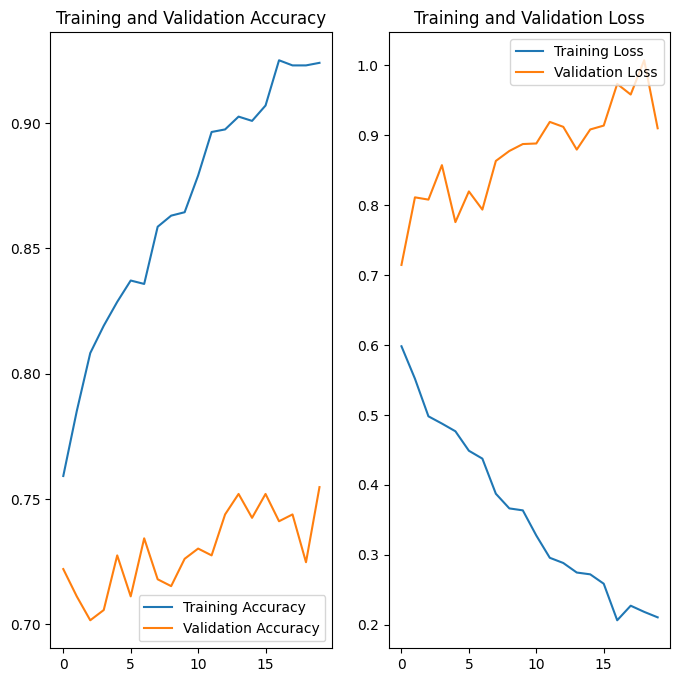

Model saved!


In [10]:
# train the model

epochs = 20 # количество эпох тренировки
history = model.fit(
    train_ds,
    validation_data = valid_ds,
    epochs=epochs)

# visualize training and validation results

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# save the model (manual mode)
model.save_weights('my_flowers_model')
print('Model saved!')

Точность модели на валидационной выборке около 75%;
Проверим модель на другом изображении (см. файл 2)